In [1]:
# Import libraries
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import pairwise_distances
from scipy.optimize import minimize, lsq_linear
from sklearn.mixture import BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import lstsq
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Step 1: Data Preprocessing
In this step, we load the hyperspectral image data and apply the necessary preprocessing. The data consists of a hyperspectral cube with pixel data and corresponding ground truth labels. The ground truth labels represent different classes that we'll use for classification. The preprocessing also includes filtering out pixels with non-zero labels for further analysis.


In [2]:
# Load the hyperspectral data (Salinas_cube.mat)
salinas_cube = sio.loadmat('Salinas_cube.mat')['salinas_cube']
salinas_endmembers = sio.loadmat('Salinas_endmembers.mat')['salinas_endmembers']
salinas_gt = sio.loadmat('Salinas_gt.mat')['salinas_gt']  

# Check the shape of the data
print("Salinas Cube Shape:", salinas_cube.shape)  
print("Salinas Ground Truth Shape:", salinas_gt.shape) 

# Filter pixels with non-zero class labels
non_zero_mask = salinas_gt > 0
filtered_cube = salinas_cube[non_zero_mask]  # Only keep non-zero label pixels

# Use the filtered ground truth labels for classification
y_classification = salinas_gt[non_zero_mask]

# Print the number of non-zero pixels
print(f"Number of non-zero pixels: {filtered_cube.shape[0]}")

Salinas Cube Shape: (220, 120, 204)
Salinas Ground Truth Shape: (220, 120)
Number of non-zero pixels: 16929


## Spectral Unmixing - Least Squares (Standard)

Abundance Maps Shape (Least Squares): (16929, 7)


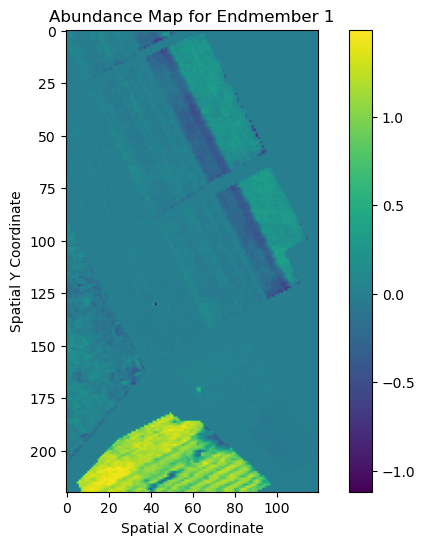

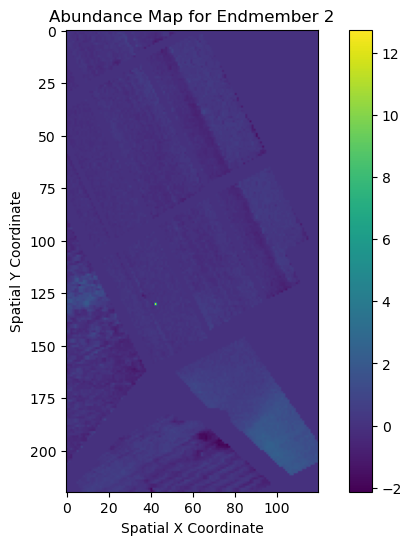

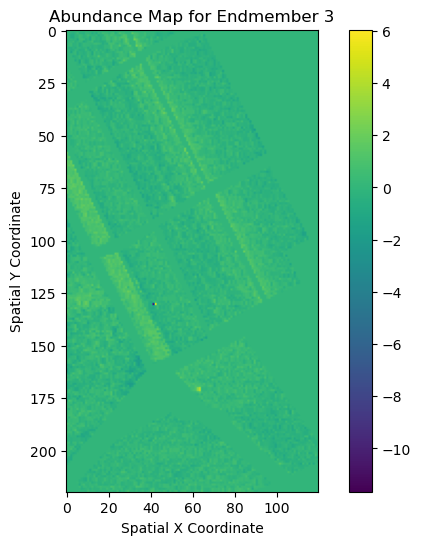

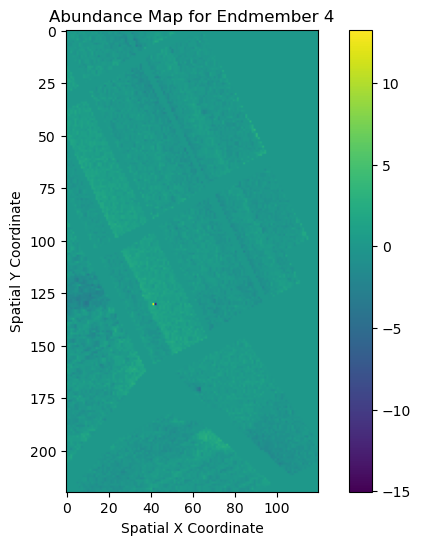

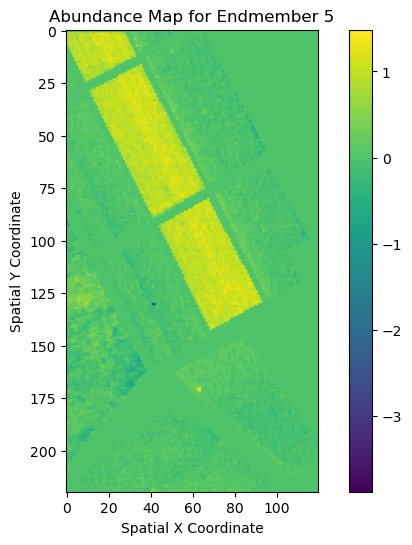

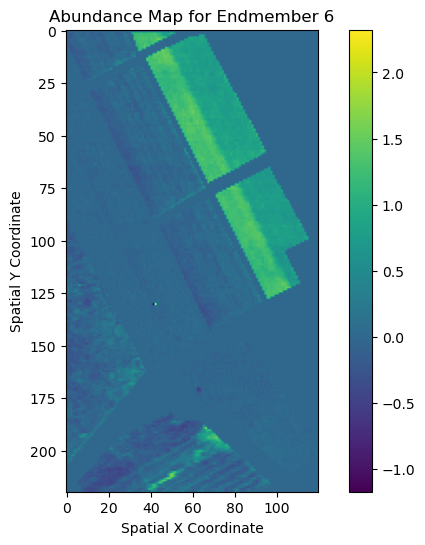

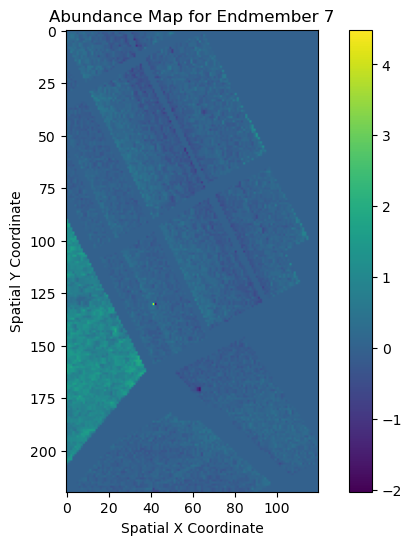

Average Reconstruction Error (Least Squares): 157.43990455175236


In [3]:
# Hypothetical endmember spectral signatures (pure pixels) for the 7 materials
# These would typically be extracted from the data, but for now, we assume them.
# Shape should be (L, 7), where L is the number of spectral bands (204 here)
# Placeholder endmembers (random initialization)
np.random.seed(0)  # For reproducibility
num_endmembers = 7
L = salinas_cube.shape[2]  # Number of spectral bands
X = salinas_endmembers   

# Least Squares Unmixing for each pixel
abundance_maps_ls = []

for pixel in filtered_cube:
    # Solve y = X * θ for θ using least squares
    theta_ls, _, _, _ = lstsq(X, pixel, cond=None)
    abundance_maps_ls.append(theta_ls)

# Convert to a numpy array for further processing (each row is a pixel's abundance vector)
abundance_maps_ls = np.array(abundance_maps_ls)

# Print shape of abundance maps
print("Abundance Maps Shape (Least Squares):", abundance_maps_ls.shape)

# Get the original shape of the hyperspectral cube
n_rows, n_cols = salinas_gt.shape  # Spatial dimensions (220, 120)

# Step 2 (A) (i): Derive and plot abundance maps for each endmember
for i in range(num_endmembers):
    # Create a blank map with the original spatial dimensions (220, 120)
    abundance_map_full = np.zeros((n_rows, n_cols))
    
    # Fill the abundance map with values from the filtered pixels
    abundance_map_full[non_zero_mask] = abundance_maps_ls[:, i]
    
    # Plot the abundance map
    plt.figure(figsize=(8, 6))
    plt.imshow(abundance_map_full, cmap='viridis')  # Use imshow for 2D map
    plt.colorbar()
    plt.title(f"Abundance Map for Endmember {i+1}")
    plt.xlabel('Spatial X Coordinate')
    plt.ylabel('Spatial Y Coordinate')
    plt.show()

# Step 2 (A) (ii): Compute the reconstruction error
reconstruction_errors = np.linalg.norm(filtered_cube - abundance_maps_ls @ X.T, axis=1)
average_reconstruction_error = np.mean(reconstruction_errors)

print(f"Average Reconstruction Error (Least Squares): {average_reconstruction_error}")

## Spectral Unmixing - Sum-to-One Constraint
This section performs spectral unmixing using the least squares method with a sum-to-one constraint. Each pixel is represented as a linear combination of endmembers, and the abundance values (coefficients) for each endmember are constrained to sum to 1. This helps ensure that the relative proportions of each endmember in a pixel are physically meaningful.


Abundance Maps Shape (Sum-to-One Constraint): (16929, 7)


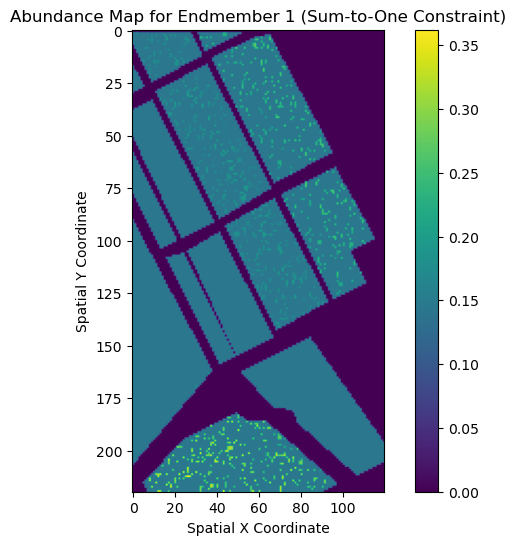

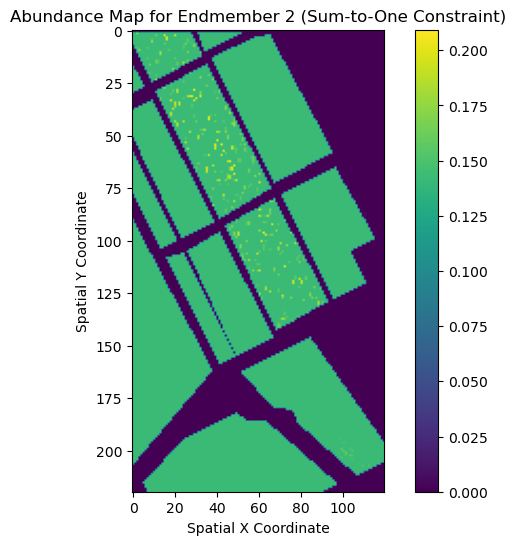

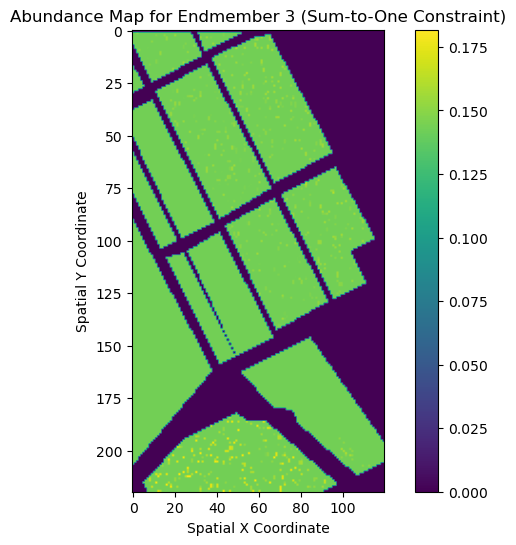

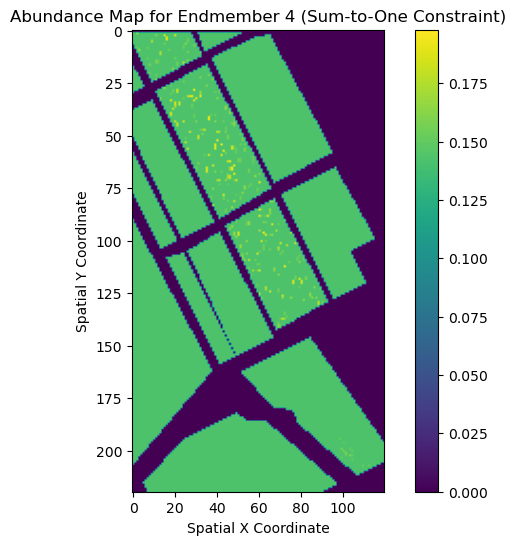

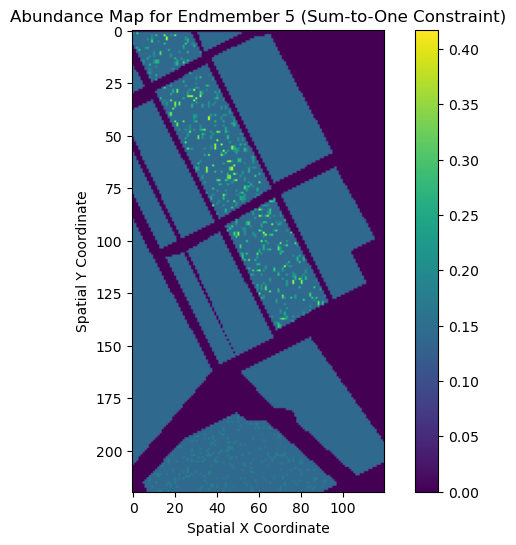

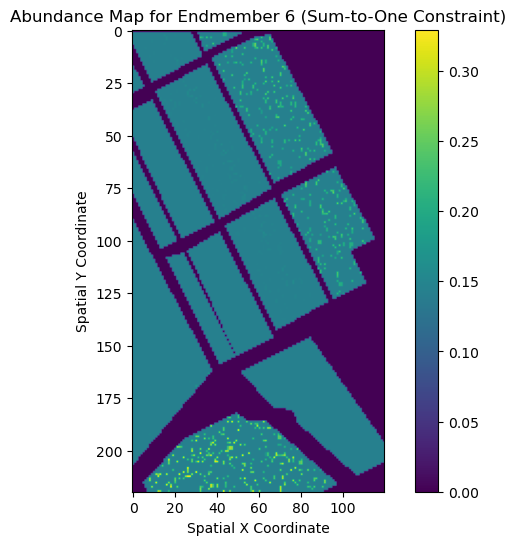

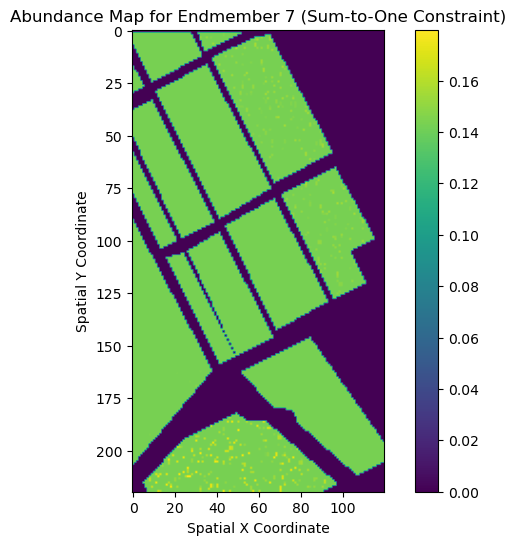

Average Reconstruction Error (Sum-to-One Constraint): 8655.536136801233


In [4]:
# Function to compute the residual (reconstruction error) with sum-to-one constraint
def residual_sum_to_one(theta, X, y):
    reconstruction = X @ theta
    error = np.linalg.norm(y - reconstruction)**2
    return error

# Constraint: The sum of the abundance vector must be 1
def sum_to_one_constraint(theta):
    return np.sum(theta) - 1

# Perform least squares unmixing with sum-to-one constraint for each pixel
abundance_maps_sum_to_one = []

for pixel in filtered_cube:
    # Initial guess for abundance vector (uniform distribution)
    theta_initial = np.ones(num_endmembers) / num_endmembers
    
    # Define the constraints and bounds for the optimization
    constraints = {'type': 'eq', 'fun': sum_to_one_constraint}
    bounds = [(0, None) for _ in range(num_endmembers)]  # Abundances must be non-negative
    
    # Solve the optimization problem
    result = minimize(residual_sum_to_one, theta_initial, args=(X, pixel), 
                      constraints={'type': 'eq', 'fun': sum_to_one_constraint}, 
                      bounds=[(0, None)] * num_endmembers)
    
    # Store the abundance vector
    abundance_maps_sum_to_one.append(result.x)

# Convert to a numpy array for further processing (each row is a pixel's abundance vector)
abundance_maps_sum_to_one = np.array(abundance_maps_sum_to_one)

# Print shape of abundance maps
print("Abundance Maps Shape (Sum-to-One Constraint):", abundance_maps_sum_to_one.shape)

# Step 2 (A) (i): Derive and plot abundance maps for each endmember
for i in range(num_endmembers):
    # Create a blank map with the original spatial dimensions (220, 120)
    abundance_map_full = np.zeros((n_rows, n_cols))
    
    # Fill the abundance map with values from the filtered pixels
    abundance_map_full[non_zero_mask] = abundance_maps_sum_to_one[:, i]
    
    # Plot the abundance map
    plt.figure(figsize=(8, 6))
    plt.imshow(abundance_map_full, cmap='viridis')  # Use imshow for 2D map
    plt.colorbar()
    plt.title(f"Abundance Map for Endmember {i+1} (Sum-to-One Constraint)")
    plt.xlabel('Spatial X Coordinate')
    plt.ylabel('Spatial Y Coordinate')
    plt.show()

# Step 2 (A) (ii): Compute the reconstruction error
reconstruction_errors_sum_to_one = np.linalg.norm(filtered_cube - abundance_maps_sum_to_one @ X.T, axis=1)
average_reconstruction_error_sum_to_one = np.mean(reconstruction_errors_sum_to_one)

print(f"Average Reconstruction Error (Sum-to-One Constraint): {average_reconstruction_error_sum_to_one}")

## Spectral Unmixing - Least Squares with Non-Negativity Constraint
Here, we perform least squares spectral unmixing with the additional constraint that all abundance values must be non-negative. This prevents the model from predicting physically unrealistic negative proportions for the endmembers.

Abundance Maps Shape (Non-Negativity Constraint): (16929, 7)


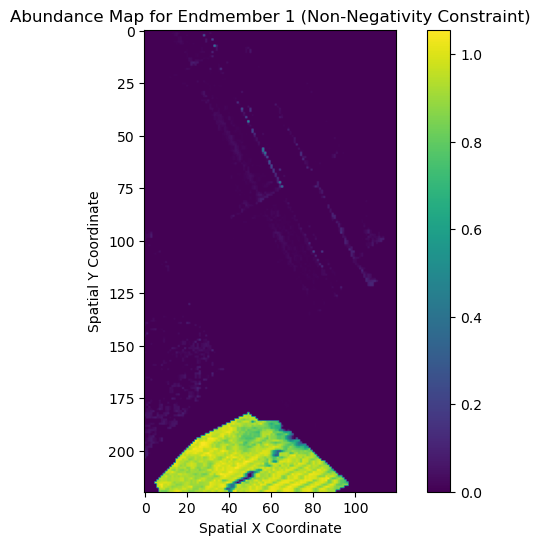

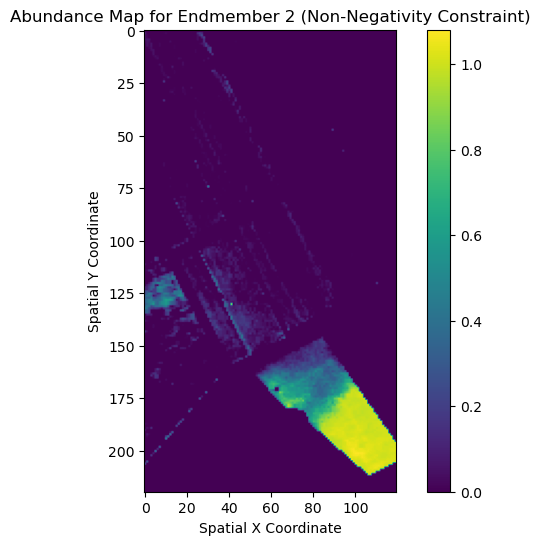

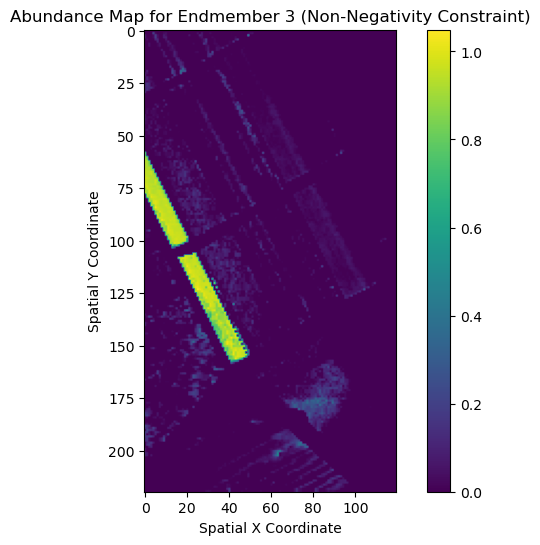

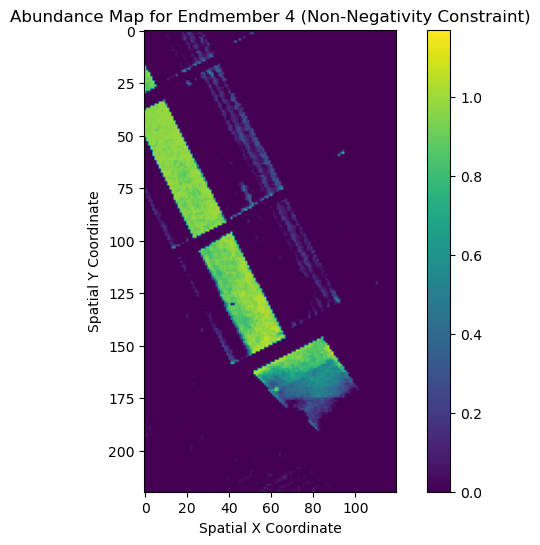

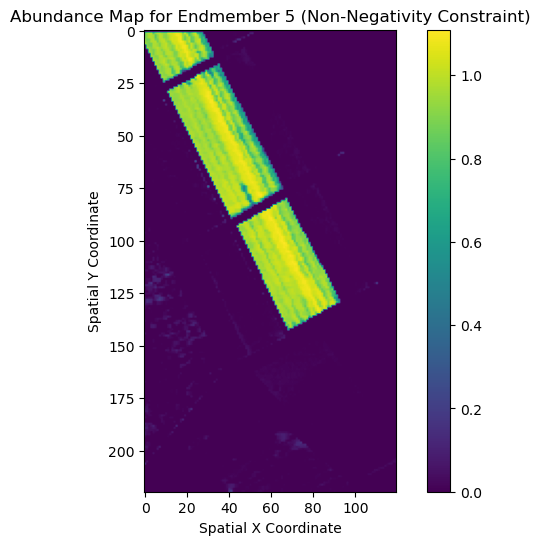

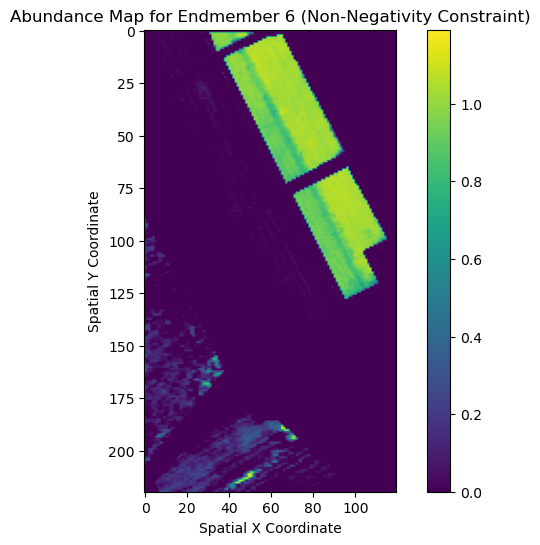

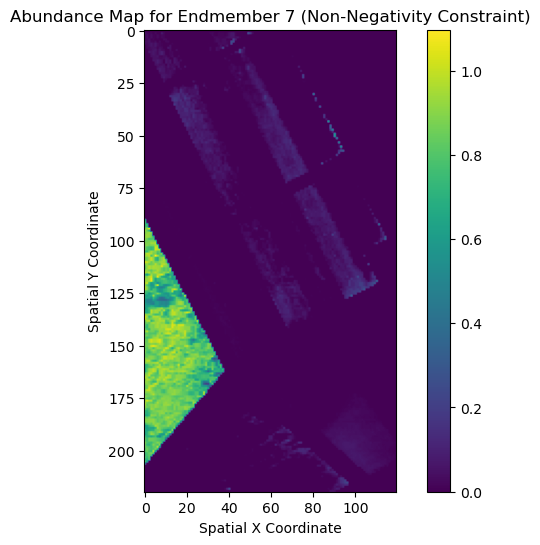

Average Reconstruction Error (Non-Negativity Constraint): 320.5460052744223


In [5]:
# Perform least squares unmixing with non-negativity constraint for each pixel
abundance_maps_non_negativity = []

for pixel in filtered_cube:
    # Solve y = X * θ subject to θ >= 0 (non-negative abundance values)
    result = lsq_linear(X, pixel, bounds=(0, np.inf))
    
    # Store the abundance vector
    abundance_maps_non_negativity.append(result.x)

# Convert to a numpy array for further processing (each row is a pixel's abundance vector)
abundance_maps_non_negativity = np.array(abundance_maps_non_negativity)

# Print shape of abundance maps
print("Abundance Maps Shape (Non-Negativity Constraint):", abundance_maps_non_negativity.shape)

# Step 2 (A) (i): Derive and plot abundance maps for each endmember
for i in range(num_endmembers):
    # Create a blank map with the original spatial dimensions (220, 120)
    abundance_map_full = np.zeros((n_rows, n_cols))
    
    # Fill the abundance map with values from the filtered pixels
    abundance_map_full[non_zero_mask] = abundance_maps_non_negativity[:, i]
    
    # Plot the abundance map
    plt.figure(figsize=(8, 6))
    plt.imshow(abundance_map_full, cmap='viridis')  # Use imshow for 2D map
    plt.colorbar()
    plt.title(f"Abundance Map for Endmember {i+1} (Non-Negativity Constraint)")
    plt.xlabel('Spatial X Coordinate')
    plt.ylabel('Spatial Y Coordinate')
    plt.show()

# Step 2 (A) (ii): Compute the reconstruction error
reconstruction_errors_non_negativity = np.linalg.norm(filtered_cube - abundance_maps_non_negativity @ X.T, axis=1)
average_reconstruction_error_non_negativity = np.mean(reconstruction_errors_non_negativity)

print(f"Average Reconstruction Error (Non-Negativity Constraint): {average_reconstruction_error_non_negativity}")

## Spectral Unmixing - Non-Negativity + Sum-to-One Constraint
In this step, we combine the non-negativity and sum-to-one constraints for spectral unmixing. This method ensures that all abundance values are non-negative and sum to one, which helps better represent the physical properties of the hyperspectral image.


Abundance Maps Shape (Non-Negativity + Sum-to-One Constraints): (16929, 7)


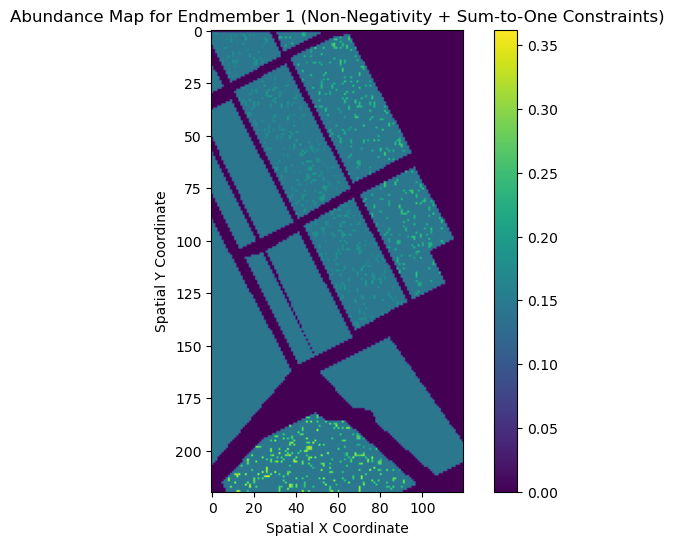

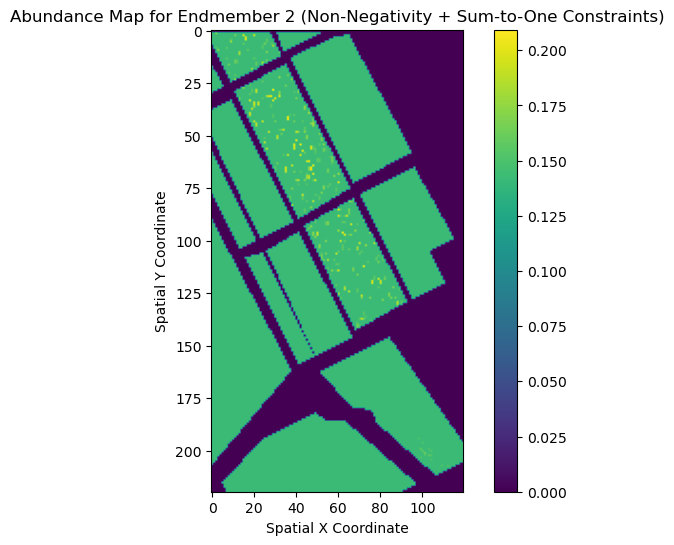

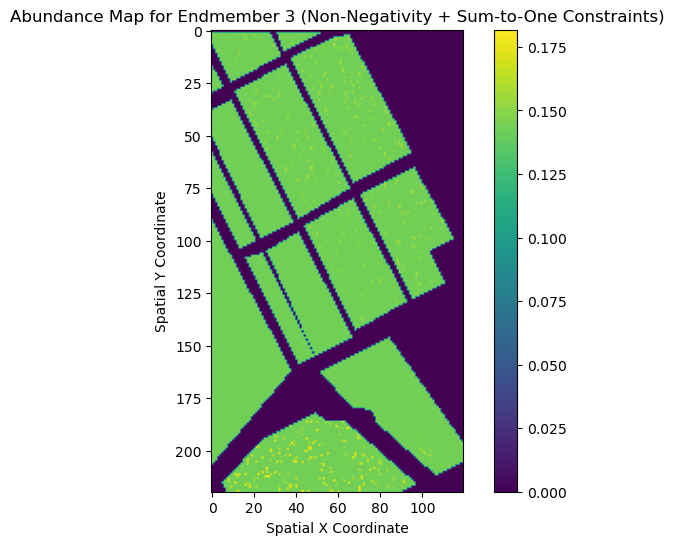

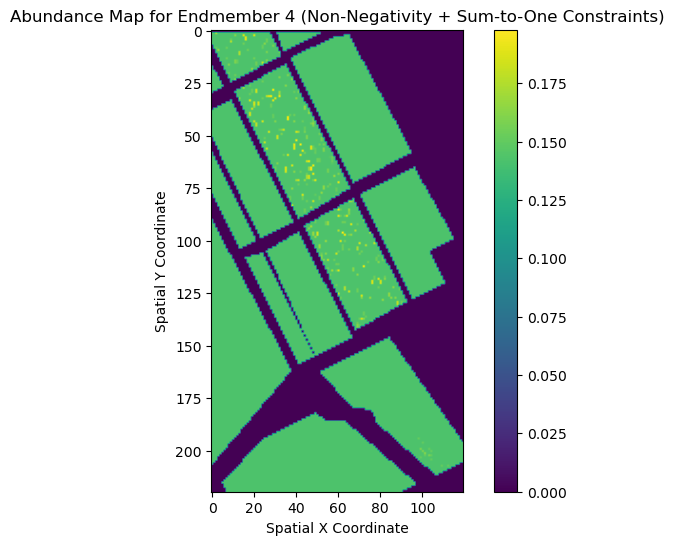

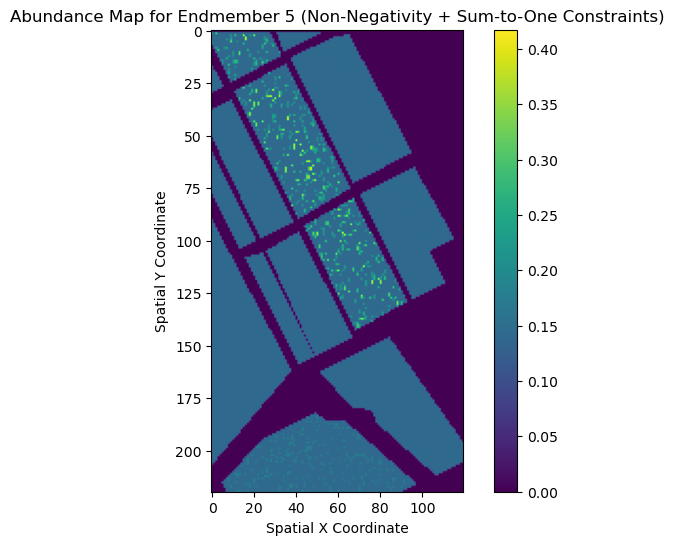

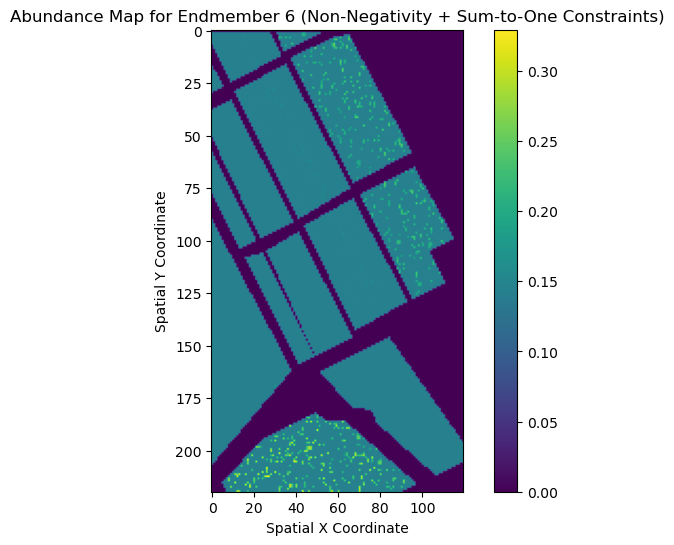

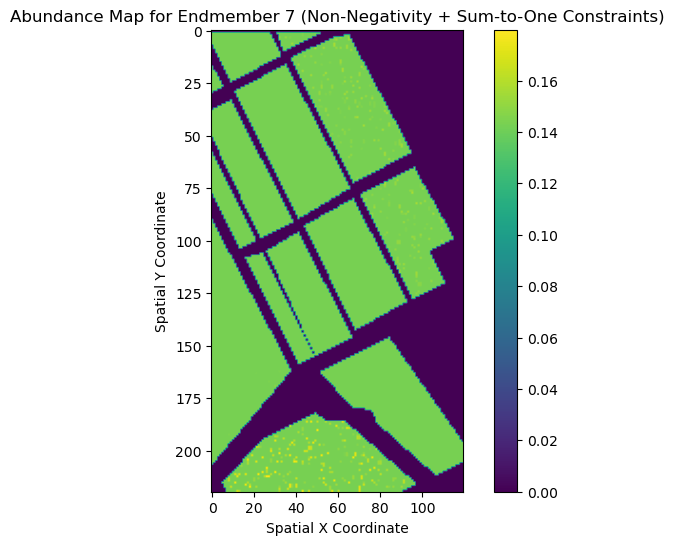

Average Reconstruction Error (Non-Negativity + Sum-to-One Constraints): 8655.536136801233


In [6]:
# Function to compute the residual (reconstruction error) with both constraints
def residual_nonneg_sum_to_one(theta, X, y):
    reconstruction = X @ theta
    error = np.linalg.norm(y - reconstruction)**2
    return error

# Perform least squares unmixing with non-negativity and sum-to-one constraints for each pixel
abundance_maps_nonneg_sum_to_one = []

for pixel in filtered_cube:
    # Initial guess for abundance vector (uniform distribution)
    theta_initial = np.ones(num_endmembers) / num_endmembers
    
    result = minimize(residual_nonneg_sum_to_one, theta_initial, args=(X, pixel), 
                      constraints={'type': 'eq', 'fun': sum_to_one_constraint}, 
                      bounds=[(0, None)] * num_endmembers)
    
    # Store the abundance vector
    abundance_maps_nonneg_sum_to_one.append(result.x)

# Convert to a numpy array for further processing (each row is a pixel's abundance vector)
abundance_maps_nonneg_sum_to_one = np.array(abundance_maps_nonneg_sum_to_one)

# Print shape of abundance maps
print("Abundance Maps Shape (Non-Negativity + Sum-to-One Constraints):", abundance_maps_nonneg_sum_to_one.shape)

# Step 2 (A) (i): Derive and plot abundance maps for each endmember
for i in range(num_endmembers):
    # Create a blank map with the original spatial dimensions (220, 120)
    abundance_map_full = np.zeros((n_rows, n_cols))
    
    # Fill the abundance map with values from the filtered pixels
    abundance_map_full[non_zero_mask] = abundance_maps_nonneg_sum_to_one[:, i]
    
    # Plot the abundance map
    plt.figure(figsize=(8, 6))
    plt.imshow(abundance_map_full, cmap='viridis')  # Use imshow for 2D map
    plt.colorbar()
    plt.title(f"Abundance Map for Endmember {i+1} (Non-Negativity + Sum-to-One Constraints)")
    plt.xlabel('Spatial X Coordinate')
    plt.ylabel('Spatial Y Coordinate')
    plt.show()

# Step 2 (A) (ii): Compute the reconstruction error
reconstruction_errors_nonneg_sum_to_one = np.linalg.norm(filtered_cube - abundance_maps_nonneg_sum_to_one @ X.T, axis=1)
average_reconstruction_error_nonneg_sum_to_one = np.mean(reconstruction_errors_nonneg_sum_to_one)

print(f"Average Reconstruction Error (Non-Negativity + Sum-to-One Constraints): {average_reconstruction_error_nonneg_sum_to_one}")

## Spectral Unmixing - LASSO (L1 Regularization)
LASSO introduces sparsity in the abundance values by applying L1 regularization. This can help simplify the model by zeroing out less important endmembers, making the model more interpretable and potentially more accurate.


Abundance Maps Shape (LASSO): (16929, 7)


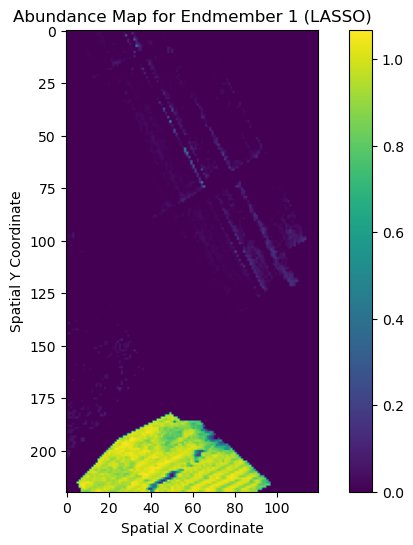

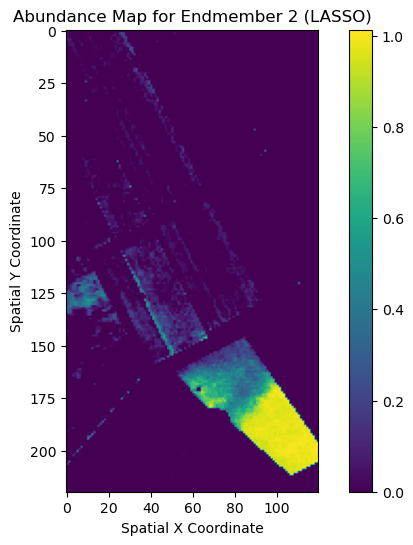

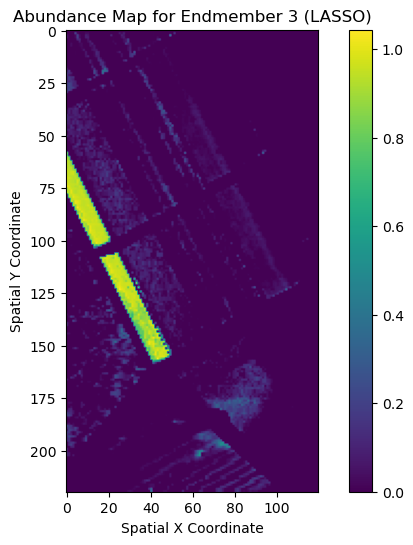

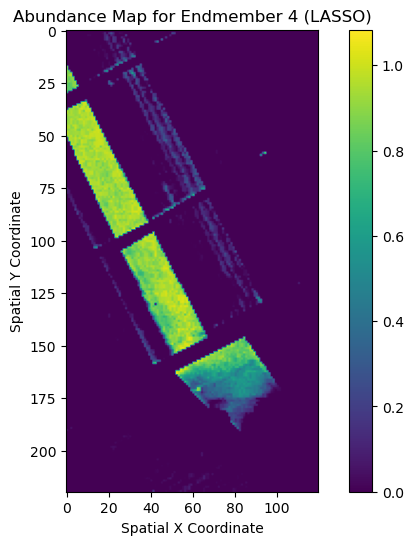

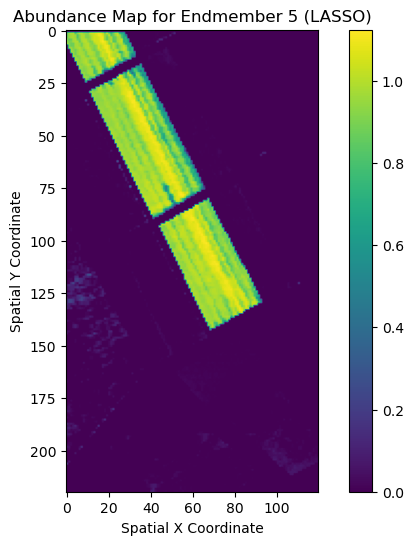

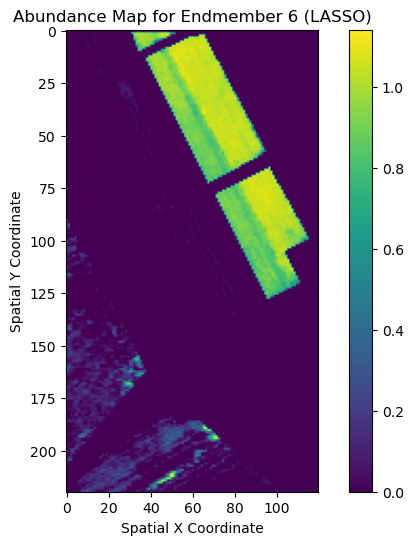

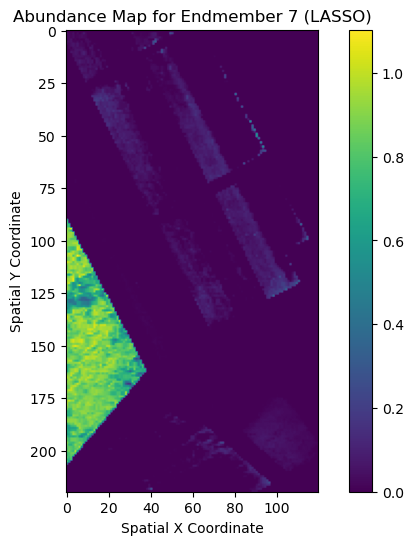

Average Reconstruction Error (LASSO): 355.09777209534127


In [7]:
# Suppress only ConvergenceWarning from sklearn
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Regularization strength (alpha): You may adjust this value depending on the problem
alpha = 0.01  # L1 regularization strength

# Perform LASSO for each pixel
abundance_maps_lasso = []

lasso_model = Lasso(alpha=alpha, positive=True, max_iter=5000)  # Ensure non-negative abundance values

for pixel in filtered_cube:
    # Fit LASSO model to obtain sparse abundance vector
    lasso_model.fit(X, pixel)
    abundance_maps_lasso.append(lasso_model.coef_)

# Convert to a numpy array for further processing (each row is a pixel's abundance vector)
abundance_maps_lasso = np.array(abundance_maps_lasso)

# Print shape of abundance maps
print("Abundance Maps Shape (LASSO):", abundance_maps_lasso.shape)

# Step 2 (A) (i): Derive and plot abundance maps for each endmember
for i in range(num_endmembers):
    # Create a blank map with the original spatial dimensions (220, 120)
    abundance_map_full = np.zeros((n_rows, n_cols))
    
    # Fill the abundance map with values from the filtered pixels
    abundance_map_full[non_zero_mask] = abundance_maps_lasso[:, i]
    
    # Plot the abundance map
    plt.figure(figsize=(8, 6))
    plt.imshow(abundance_map_full, cmap='viridis')  # Use imshow for 2D map
    plt.colorbar()
    plt.title(f"Abundance Map for Endmember {i+1} (LASSO)")
    plt.xlabel('Spatial X Coordinate')
    plt.ylabel('Spatial Y Coordinate')
    plt.show()

# Step 2 (A) (ii): Compute the reconstruction error
reconstruction_errors_lasso = np.linalg.norm(filtered_cube - abundance_maps_lasso @ X.T, axis=1)
average_reconstruction_error_lasso = np.mean(reconstruction_errors_lasso)

print(f"Average Reconstruction Error (LASSO): {average_reconstruction_error_lasso}")

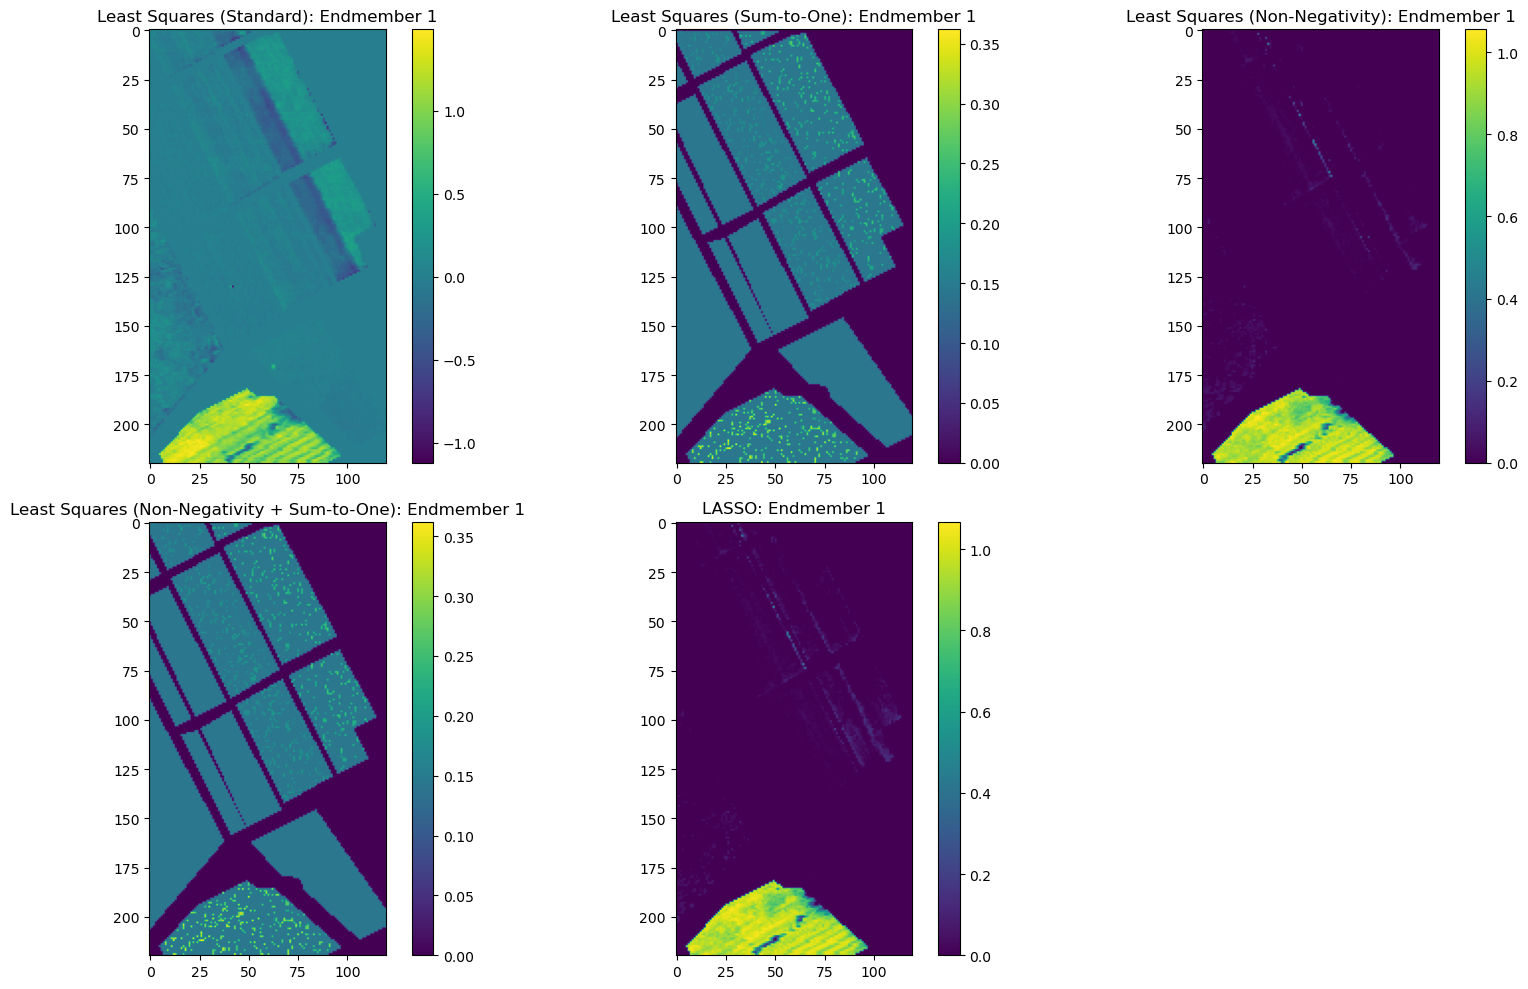

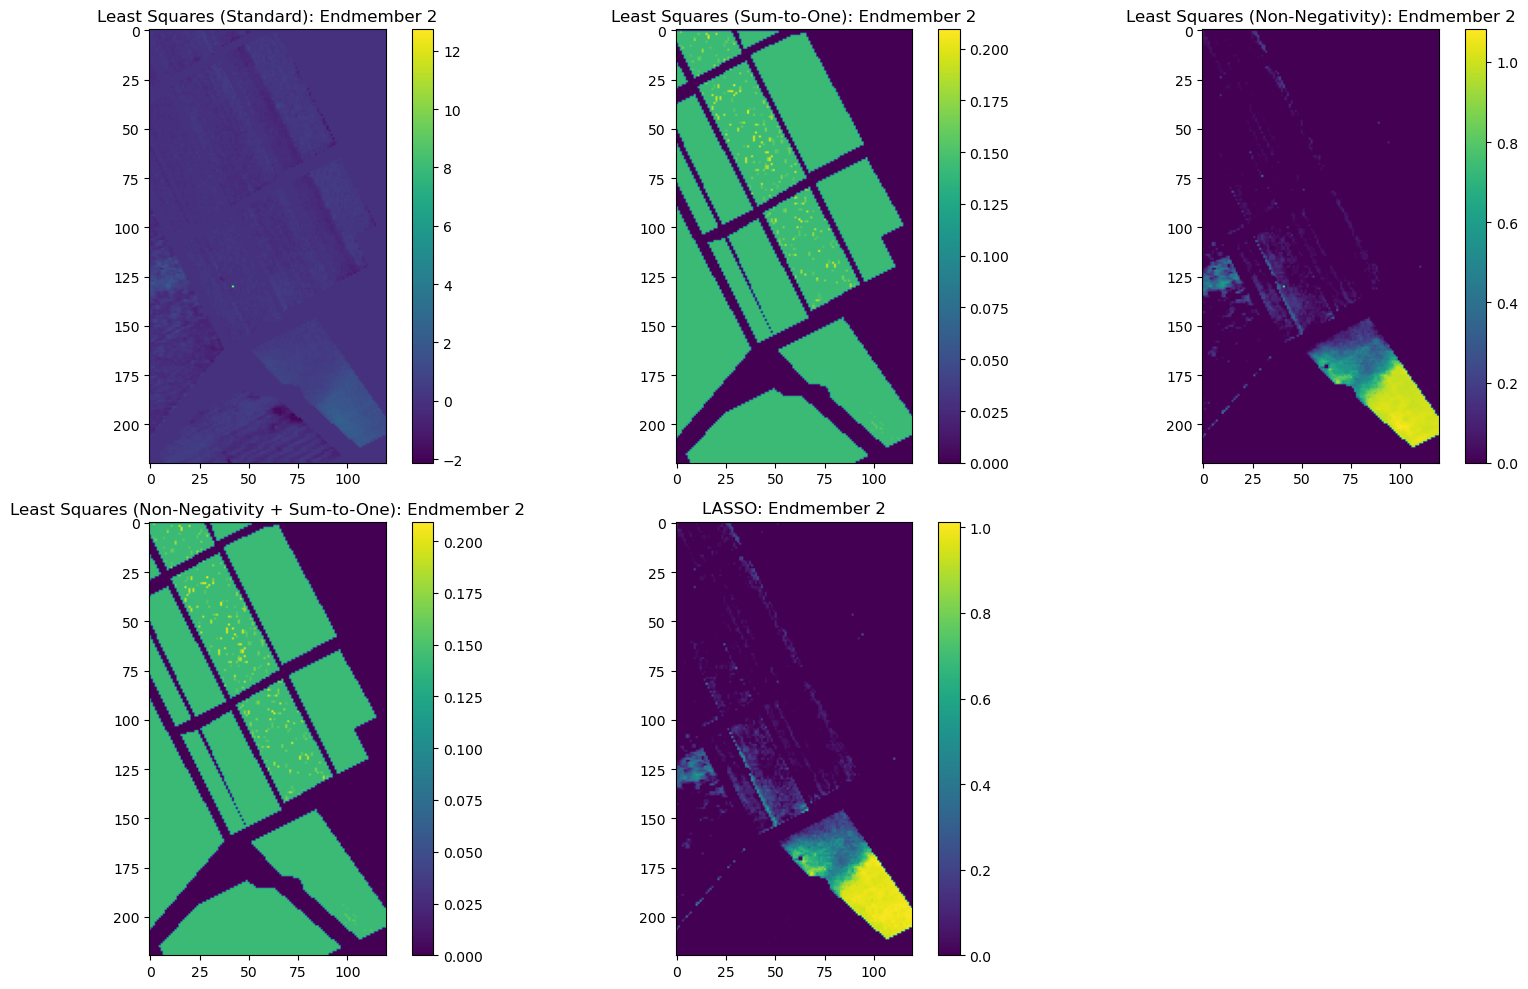

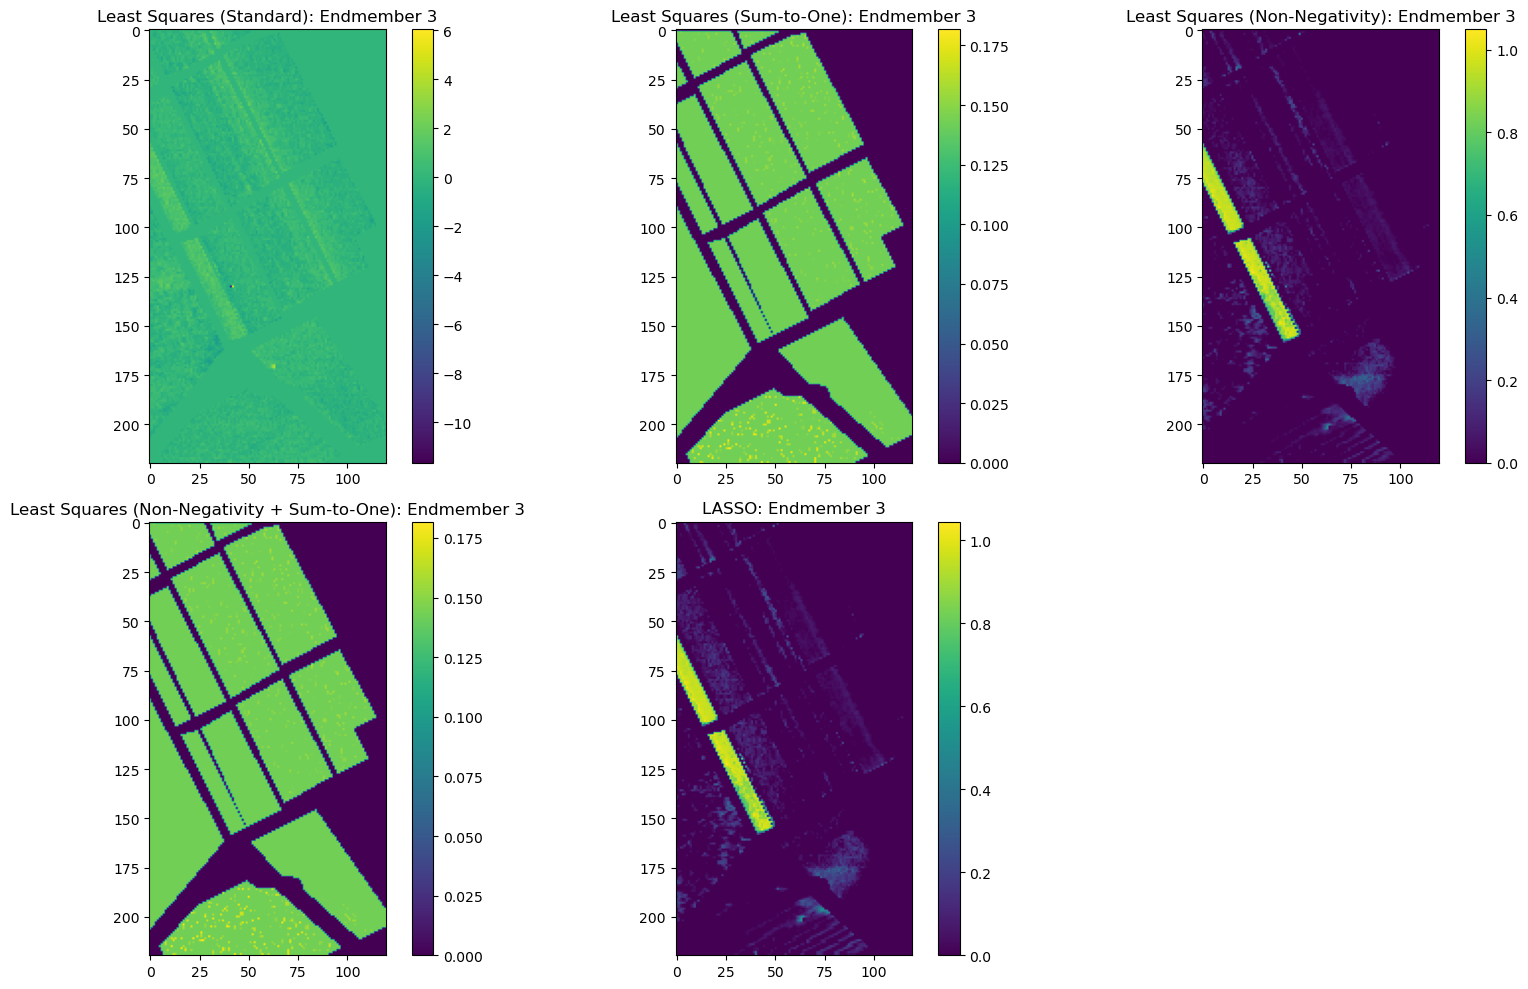

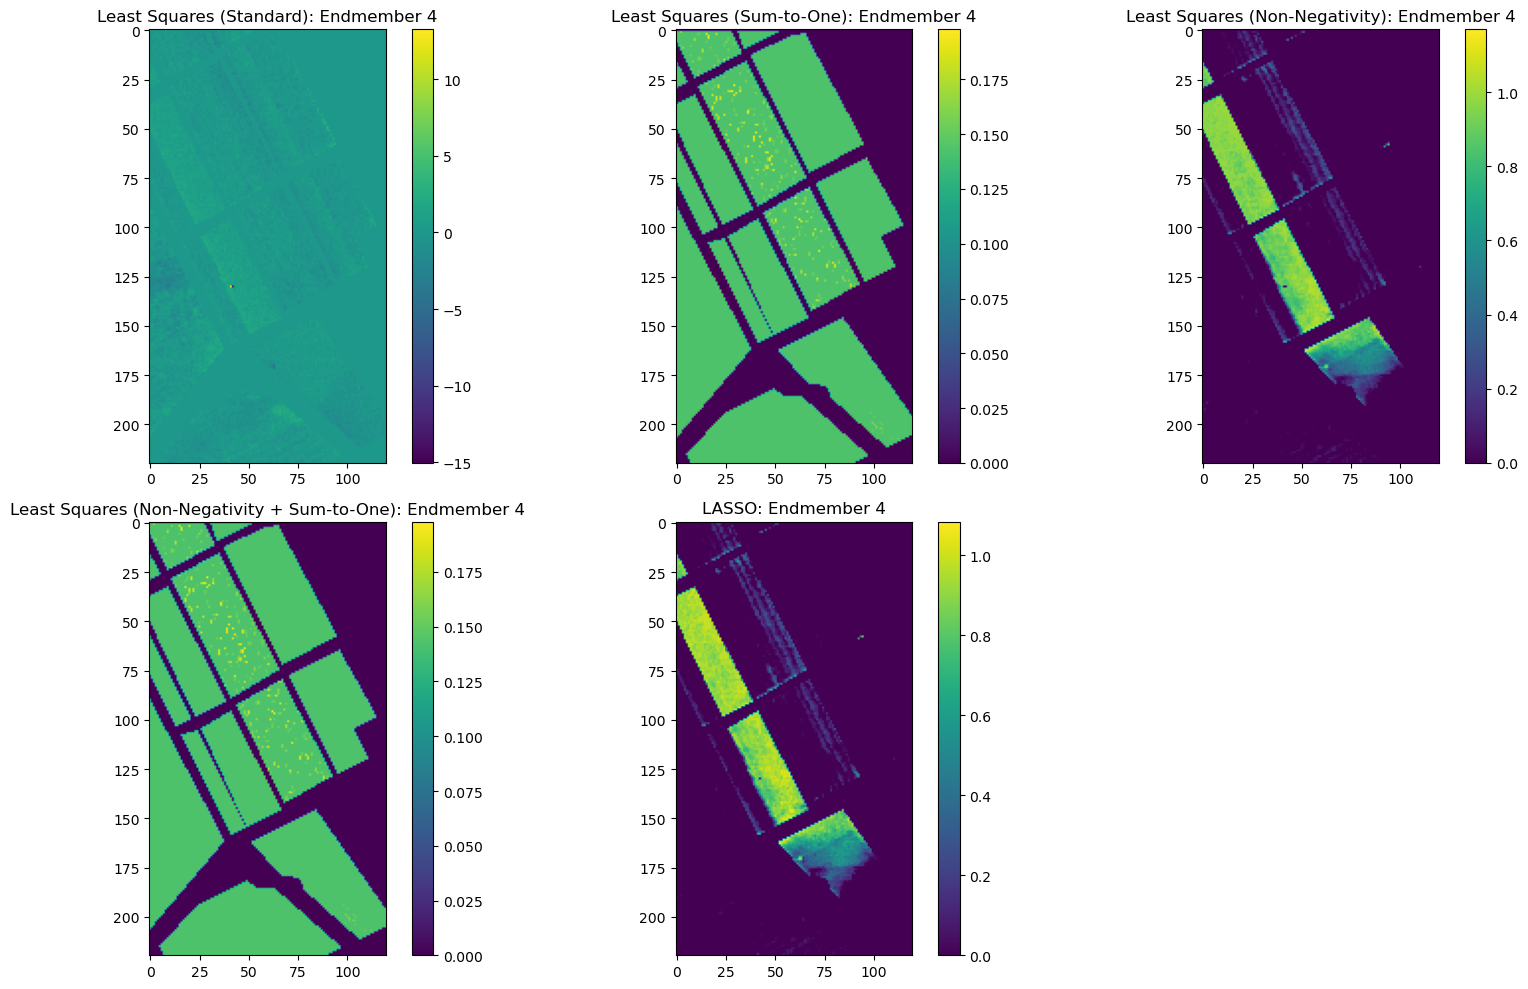

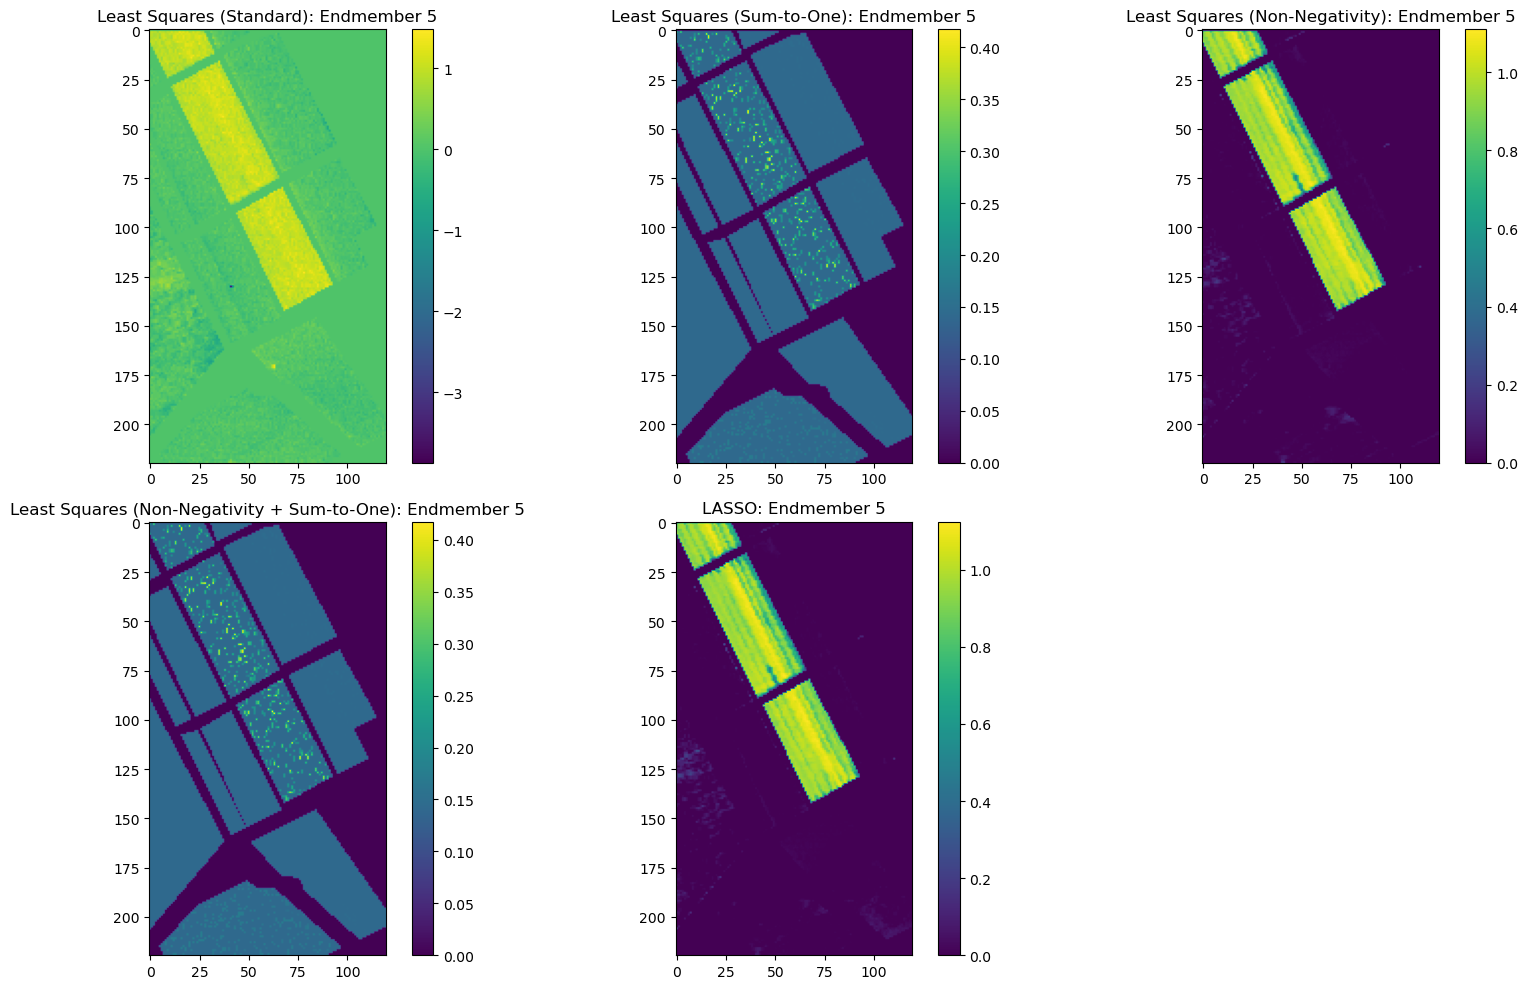

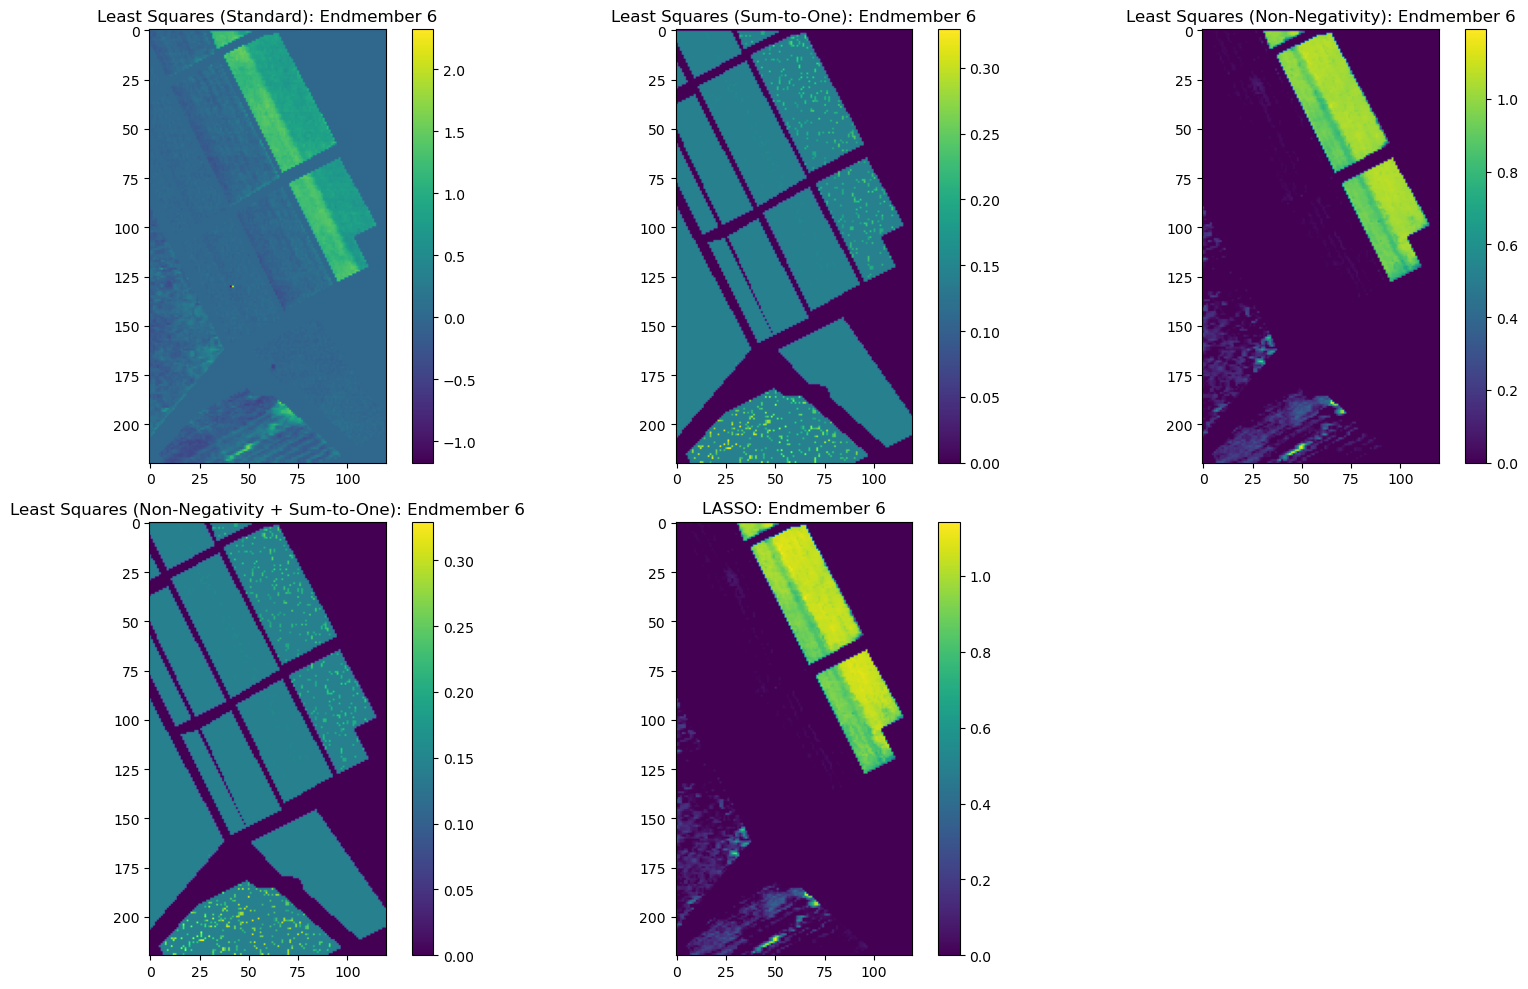

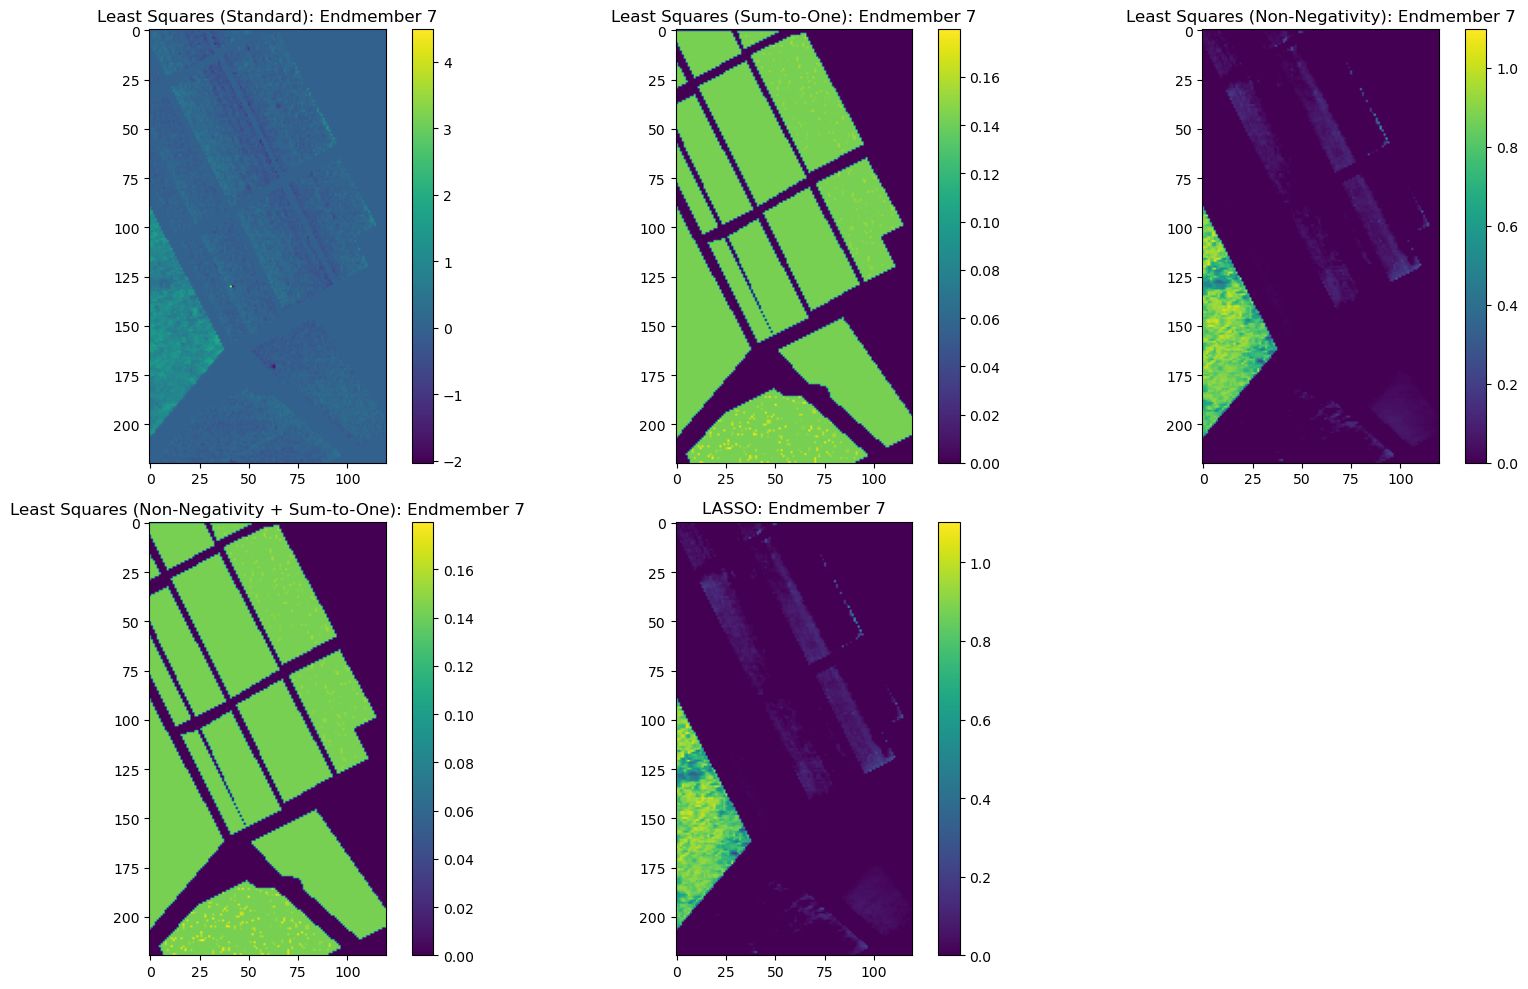

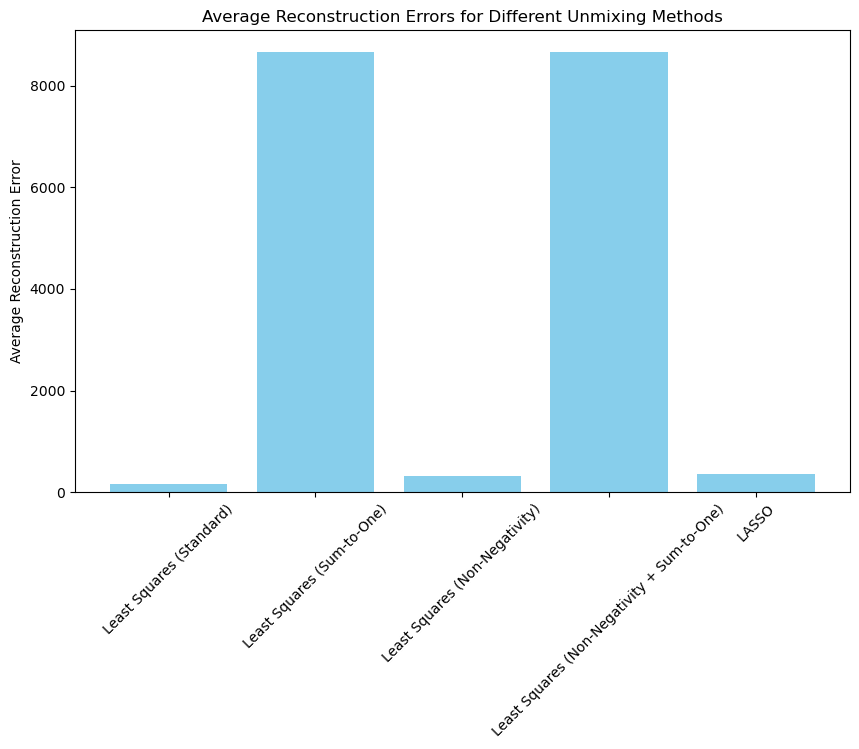

In [8]:
# Step 3: Comparison of Results

methods = ["Least Squares (Standard)", 
           "Least Squares (Sum-to-One)", 
           "Least Squares (Non-Negativity)", 
           "Least Squares (Non-Negativity + Sum-to-One)", 
           "LASSO"]

# List of abundance maps and reconstruction errors from each method
abundance_maps_list = [abundance_maps_ls, 
                       abundance_maps_sum_to_one, 
                       abundance_maps_non_negativity, 
                       abundance_maps_nonneg_sum_to_one, 
                       abundance_maps_lasso]

reconstruction_errors_list = [average_reconstruction_error, 
                              average_reconstruction_error_sum_to_one, 
                              average_reconstruction_error_non_negativity, 
                              average_reconstruction_error_nonneg_sum_to_one, 
                              average_reconstruction_error_lasso]

# Visualization of Abundance Maps (Spatial Maps instead of Histograms)
n_rows, n_cols = salinas_gt.shape  # Original spatial dimensions

for i in range(num_endmembers):
    plt.figure(figsize=(16, 10))
    for j, method in enumerate(methods):
        plt.subplot(2, 3, j+1)
        
        # Reshape abundance map to spatial dimensions
        abundance_map_full = np.zeros((n_rows, n_cols))
        abundance_map_full[non_zero_mask] = abundance_maps_list[j][:, i]
        
        # Plot the abundance map
        plt.imshow(abundance_map_full, cmap='viridis')
        plt.colorbar()
        plt.title(f"{method}: Endmember {i+1}")
    
    plt.tight_layout()
    plt.show()

# Reconstruction Error Comparison
plt.figure(figsize=(10, 6))
plt.bar(methods, reconstruction_errors_list, color='skyblue')
plt.title("Average Reconstruction Errors for Different Unmixing Methods")
plt.ylabel("Average Reconstruction Error")
plt.xticks(rotation=45)
plt.show()

## Supervised Classification - Naïve Bayes Classifier
This step introduces the Naïve Bayes classifier, which assumes that the features (abundance maps) are conditionally independent given the class label. We apply 10-fold cross-validation to evaluate the model and train the classifier on the entire dataset for final predictions.


In [9]:
# Prepare the features (X) and labels (y) for classification
X_classification = abundance_maps_ls  # Using abundance maps from least squares as features
y_classification = salinas_gt[non_zero_mask]  # Non-zero classification labels

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4(A) (i): Naïve Bayes Classifier with 10-fold cross-validation
nb_classifier = GaussianNB()
cv_scores_nb = cross_val_score(nb_classifier, X_train, y_train, cv=10)  # 10-fold cross-validation

# Report the mean and standard deviation of validation error
validation_error_nb = 1 - np.mean(cv_scores_nb)
validation_std_nb = np.std(cv_scores_nb)
print(f"Naïve Bayes Validation Error: {validation_error_nb:.4f} (±{validation_std_nb:.4f})")

Naïve Bayes Validation Error: 0.0521 (±0.0060)


Naïve Bayes Success Rate: 0.9460
Confusion Matrix (Naïve Bayes):
[[443   0   1   0   0   0   0]
 [  2 424   0   0   0   0  23]
 [  1   0 272   0  84   0   0]
 [  0   0   0 134  28   0   0]
 [  5   0  12  17 404   1   0]
 [  7   0   0   0   0 788   2]
 [  0   0   0   0   0   0 738]]


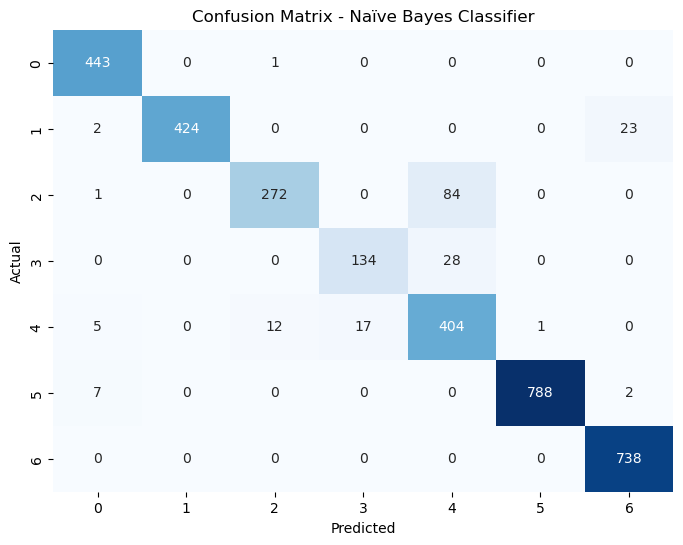

In [10]:
# Train Naïve Bayes on the full training set and evaluate on the test set
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)

# Confusion matrix and success rate
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
success_rate_nb = accuracy_score(y_test, y_pred_nb)

print(f"Naïve Bayes Success Rate: {success_rate_nb:.4f}")
print("Confusion Matrix (Naïve Bayes):")
print(conf_matrix_nb)

# Visualize the confusion matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Naïve Bayes Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Supervised Classification - Minimum Euclidean Distance Classifier
The Euclidean Distance Classifier assigns each test sample to the class of the nearest training sample based on Euclidean distance in the feature space. This classifier is simple and effective, especially when the classes are well-separated in the feature space. 

We perform 10-fold cross-validation to evaluate the classifier and compute the validation error. Finally, the classifier is trained on the entire training set, and predictions are made on the test set to assess the overall accuracy and generate a confusion matrix.


In [11]:
def euclidean_distance_classifier(X_train, y_train, X_test):
    # Compute the class centroids (mean of each class in the training set)
    class_labels = np.unique(y_train)
    centroids = np.array([np.mean(X_train[y_train == label], axis=0) for label in class_labels])
    
    # Compute distances from each test sample to all centroids
    distances = pairwise_distances(X_test, centroids)
    
    # Assign the label of the closest centroid
    y_pred = class_labels[np.argmin(distances, axis=1)]
    return y_pred

# Train-test split with updated labels
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# 10-fold cross-validation for Minimum Euclidean Distance Classifier
kf = KFold(n_splits=10, shuffle=True, random_state=42)
validation_errors = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Predict using the Euclidean Distance Classifier
    y_val_pred = euclidean_distance_classifier(X_train_fold, y_train_fold, X_val_fold)
    
    # Compute the validation error
    validation_error = 1 - accuracy_score(y_val_fold, y_val_pred)
    validation_errors.append(validation_error)

# Report the mean and standard deviation of validation error
validation_error_ed = np.mean(validation_errors)
validation_std_ed = np.std(validation_errors)
print(f"Minimum Euclidean Distance Validation Error: {validation_error_ed:.4f} (±{validation_std_ed:.4f})")

Minimum Euclidean Distance Validation Error: 0.1245 (±0.0069)


Minimum Euclidean Distance Success Rate: 0.8736
Confusion Matrix (Minimum Euclidean Distance):
[[366   0  30  27  21   0   0]
 [  0 393   0   3  47   0   6]
 [  0   0 248  27  82   0   0]
 [  0   0   0 135  27   0   0]
 [  0   0   2  40 397   0   0]
 [  0   0   0  33  41 723   0]
 [  0   0   0  11  31   0 696]]


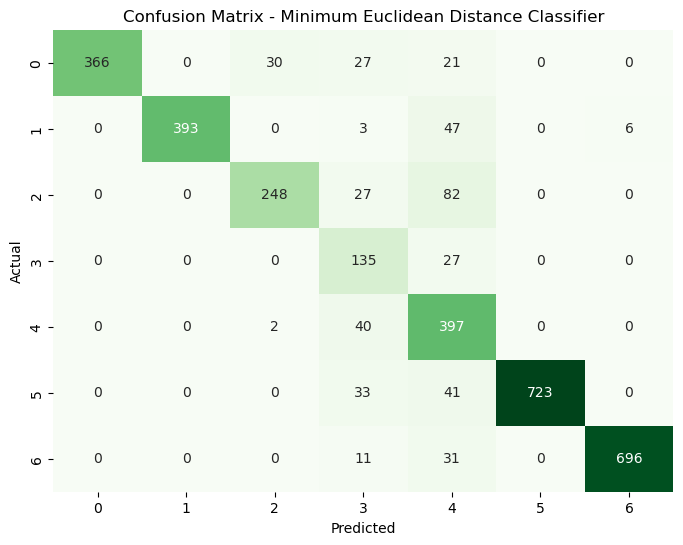

In [12]:
# Train on the full training set and evaluate on the test set
y_pred_ed = euclidean_distance_classifier(X_train, y_train, X_test)

# Confusion matrix and success rate
conf_matrix_ed = confusion_matrix(y_test, y_pred_ed)
success_rate_ed = accuracy_score(y_test, y_pred_ed)

print(f"Minimum Euclidean Distance Success Rate: {success_rate_ed:.4f}")
print("Confusion Matrix (Minimum Euclidean Distance):")
print(conf_matrix_ed)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ed, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Confusion Matrix - Minimum Euclidean Distance Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Supervised Classification - Naïve Bayes Classifier
This step introduces the Naïve Bayes classifier, which assumes that the features (abundance maps) are conditionally independent given the class label. We apply 10-fold cross-validation to evaluate the model and train the classifier on the entire dataset for final predictions.


In [13]:
# k-Nearest Neighbors Classifier

# 10-fold cross-validation for k-NN
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # Using k=5 as default
cv_scores_knn = cross_val_score(knn_classifier, X_train, y_train, cv=10)
validation_error_knn = 1 - np.mean(cv_scores_knn)
validation_std_knn = np.std(cv_scores_knn)
print(f"k-NN Validation Error: {validation_error_knn:.4f} (±{validation_std_knn:.4f})")

# Train on full training set and evaluate on test set
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

k-NN Validation Error: 0.0089 (±0.0021)


k-NN Success Rate: 0.9935
Confusion Matrix (k-NN):
[[444   0   0   0   0   0   0]
 [  0 446   0   0   0   0   3]
 [  0   0 354   0   3   0   0]
 [  0   0   0 161   1   0   0]
 [  0   0  11   2 425   0   1]
 [  0   0   0   0   0 797   0]
 [  0   1   0   0   0   0 737]]


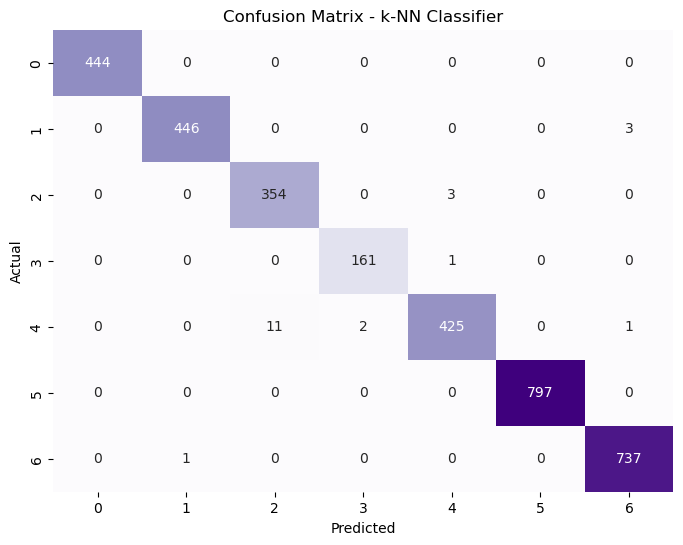

In [14]:
# Confusion matrix and success rate
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
success_rate_knn = accuracy_score(y_test, y_pred_knn)
print(f"k-NN Success Rate: {success_rate_knn:.4f}")
print("Confusion Matrix (k-NN):")
print(conf_matrix_knn)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Confusion Matrix - k-NN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Supervised Classification - Quadratic Discriminant Analysis (QDA)
In this section, we apply the Quadratic Discriminant Analysis (QDA) classifier, which models each class as following a multivariate Gaussian distribution with its own covariance matrix.

The classifier is evaluated using 10-fold cross-validation, and the final results are tested on the held-out test set to compute the accuracy and confusion matrix.


In [16]:
# Train-test split with updated labels
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Quadratic Discriminant Analysis (QDA) Classifier
qda_classifier = QuadraticDiscriminantAnalysis()

# Train the classifier
qda_classifier.fit(X_train, y_train)

# Predict on test set
y_pred_qda = qda_classifier.predict(X_test)

QDA Classifier Success Rate: 0.9923
Confusion Matrix (QDA Classifier):
[[444   0   0   0   0   0   0]
 [  0 449   0   0   0   0   0]
 [  0   0 355   0   2   0   0]
 [  0   0   1 161   0   0   0]
 [  1   0  16   2 420   0   0]
 [  0   0   0   0   0 797   0]
 [  4   0   0   0   0   0 734]]


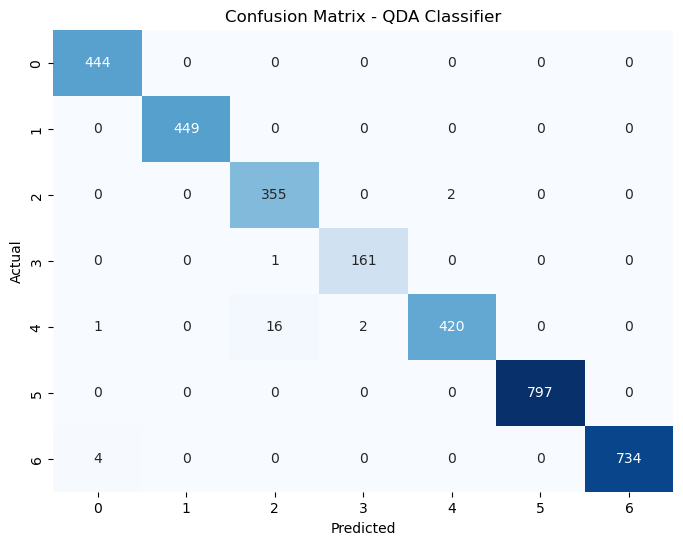

In [17]:
# Confusion matrix and success rate
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda)
success_rate_qda = accuracy_score(y_test, y_pred_qda)
print(f"QDA Classifier Success Rate: {success_rate_qda:.4f}")
print("Confusion Matrix (QDA Classifier):")
print(conf_matrix_qda)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - QDA Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Supervised Classification - Bayesian Classifier
In this section, we apply a Bayesian Gaussian Mixture Classifier, which models each class as a mixture of Gaussian distributions. The classifier is evaluated using 10-fold cross-validation, and the results are tested on the held-out test set.

In [18]:
# Train-test split with updated labels
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Bayesian Gaussian Mixture Classifier
bayesian_classifier = BayesianGaussianMixture(n_components=num_endmembers, covariance_type='full', max_iter=100)

# Train the classifier
bayesian_classifier.fit(X_train)

# Predict on test set
y_pred_bayesian = bayesian_classifier.predict(X_test)

Bayesian Classifier Success Rate: 0.1314
Confusion Matrix (Bayesian Classifier):
[[  0   0   0   0   0   0   0   0]
 [  0   0  27   0   0   0 417   0]
 [  0   0  21   0 428   0   0   0]
 [  0   0   0   0   0 357   0   0]
 [  0   0   0 161   0   1   0   0]
 [  0   0  13   2   0 424   0   0]
 [  0 777  20   0   0   0   0   0]
 [726   0  12   0   0   0   0   0]]


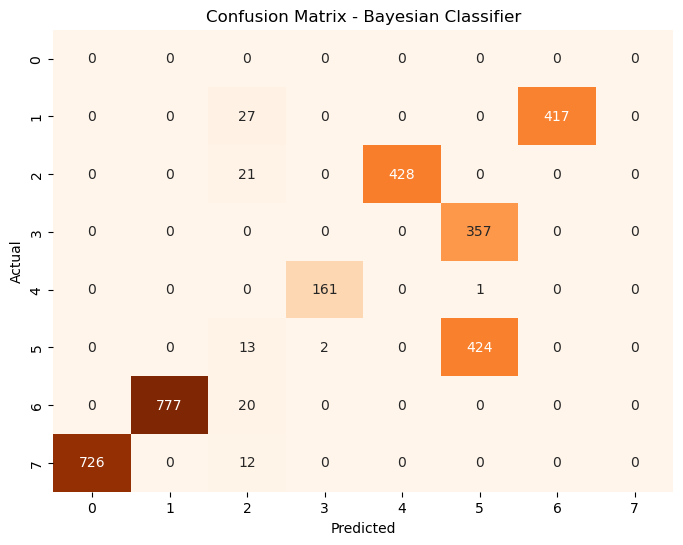

In [19]:
# Confusion matrix and success rate
conf_matrix_bayesian = confusion_matrix(y_test, y_pred_bayesian)
success_rate_bayesian = accuracy_score(y_test, y_pred_bayesian)
print(f"Bayesian Classifier Success Rate: {success_rate_bayesian:.4f}")
print("Confusion Matrix (Bayesian Classifier):")
print(conf_matrix_bayesian)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bayesian, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Confusion Matrix - Bayesian Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Comparison between QDA and Bayesian Gaussian Mixture Classifier

### Quadratic Discriminant Analysis (QDA)
Quadratic Discriminant Analysis assumes that each class follows a Gaussian distribution but allows each class to have its own covariance matrix. This flexibility makes QDA more effective when the class distributions have different shapes or orientations in the feature space. 

In the current classification task, the **QDA classifier achieved an impressive success rate of 99.23%**, demonstrating that it effectively learned the class distributions. The confusion matrix shows that the classifier correctly classified almost all the test samples with very few misclassifications across all classes. This performance suggests that the assumptions of QDA match the characteristics of the dataset, leading to highly accurate classification.

### Bayesian Gaussian Mixture Classifier
In contrast, the Bayesian Gaussian Mixture Classifier models each class as a mixture of Gaussian distributions, which can be helpful when a class consists of several sub-groups or components. However, this flexibility can also lead to overfitting or poor performance when the model struggles to learn the distribution for each class properly.

The **Bayesian classifier achieved a much lower success rate of 13.14%**, with a confusion matrix indicating that it frequently misclassified samples. Most of the predictions clustered into a few classes, indicating that the model might have had difficulty differentiating between class boundaries, possibly due to poor initialization or an inadequate number of mixture components.

Overall, QDA's assumptions about the data fit much better with this dataset, leading to more accurate classifications compared to the Bayesian Gaussian Mixture model.


## Final Results and Evaluation
The final step involves analyzing the results of the classifiers. We present the success rates, confusion matrices, and validation errors for each classifier, comparing their performance to determine the most effective model for hyperspectral image classification.
